In [4]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import random

import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (22.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')

from livelossplot import PlotLosses
from time import sleep

In [5]:
det = False

In [6]:
# parse the controller file
f = open('../COTONN/dcdc_small/controller.scs', "r")

lines = []

for line in f:
    if '#MATRIX:DATA\n' in line:                
        for line in f: # now you are at the lines you want
            # skip the #BEGIN 
            # read the state-actions
            lines = f.readlines()
            
del lines[-1]

# take the state as the train dataset
ltrain_dataset = []
for x in lines:
    ltrain_dataset.append(x.split(' ')[0])
# del ltrain_dataset[-1] # delete the string #END at the end of the file 

# convert to the numpy array with float32 data type
train_dataset = np.asarray(ltrain_dataset)
train_dataset = train_dataset.astype(np.float32)

upper_limit = train_dataset.shape[0]
num_samples = upper_limit

# take action/label pair of the state 
# take the action(s) [column 1:-1] / the rest of the integer except the state
ltrain_label = []
for x in lines:
    if det == False:
        ltrain_label.append(x.strip().split()[1:])
    else:
        ltrain_label.append(x.strip().split()[1])
# del ltrain_label[-1] # delete the string #END at the end of the file  

# convert to numpy array, note that the result is still not in one hot encoding format
train_label = np.asarray(ltrain_label)

# define number of samples
# num_samples = train_dataset.shape[0]

if det == False:
    # select to use ND or D case here
    # create now array to be filled by the encoded label
    train_label_int = [[int(i) for i in l] for l in ltrain_label]
    action_setlist = sorted(set(x for l in train_label_int for x in l))
    num_label = len(action_setlist)
    train_label_hot = np.zeros([num_samples, num_label], dtype=np.float32)
    for i,actions in enumerate(train_label_int):
        for action in actions:
            train_label_hot[i, action_setlist.index(action)] = 1
else:
    train_label_hot = train_label[:, None].astype(np.uint8)

In [7]:
len(max(ltrain_label,key=len))

2

In [8]:
train_label_hot.shape

(8677, 2)

In [9]:
train_dataset_dim = train_dataset[:, None]
# slice the samples
train_sliced = train_dataset_dim[:upper_limit]
# change it to init
train_sliced_int = train_sliced.astype(np.uint32)
# split to 4 bytes
tsi8_unordered = train_sliced_int.view(np.uint8)
# little endian format
tsi8 = np.flip(tsi8_unordered,1)
# unpack
toy_vehicle_input_unreduced = np.unpackbits(tsi8).reshape(-1,32)

# get index of MSB
msb = len(bin(int(np.max(train_dataset_dim))))-2
# get total bit
total_bit = toy_vehicle_input_unreduced.shape[1]
# reduce to the minimal binary representation
toy_vehicle_input = toy_vehicle_input_unreduced[:, np.arange(total_bit-msb,total_bit)]

num_label = train_label_hot.shape[1]

input_size = toy_vehicle_input.shape[1]

train_dataset_reform = toy_vehicle_input

In [10]:
train_dataset_reform.shape

(8677, 14)

In [11]:
def accuracy_softmax(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
  return (100.0 * np.mean(predictions == labels))

def accuracy_multilabel_softmax(predictions, labels):
    predictions_soft = np.zeros_like(predictions)
    predictions_soft[np.arange(len(predictions)), predictions.argmax(1)] = 1
    return (100.0*np.mean(labels[np.arange(len(labels)), predictions_soft.argmax(1)]))


In [12]:
tf.reset_default_graph()
batch_size = 1024 #  num_samples # (num_samples//20) # 113*6 # num_samples
num_batches = np.ceil(num_samples/batch_size)

In [13]:
print(batch_size)
print(num_batches)

1024
9.0


RNN example

In [14]:
input_size

14

In [78]:
total_series_length = num_samples
truncated_backprop_length = input_size
state_size = 1
input_rnn_size = 1

In [79]:
# 5 x 15
tf_train_dataset = tf.placeholder(tf.float32, [None, truncated_backprop_length])
# 5 x 15
tf_train_labels = tf.placeholder(tf.float32, [None, num_label])
# initial state 5 x 4
init_state = tf.placeholder(tf.float32, [None, state_size])
init_state1 = tf.placeholder(tf.float32, [None, state_size])

In [80]:
init_state

<tf.Tensor 'Placeholder_17:0' shape=(?, 20) dtype=float32>

In [81]:
init_state1

<tf.Tensor 'Placeholder_18:0' shape=(?, 20) dtype=float32>

In [82]:
init_state2 = tf.placeholder(tf.float32, [None, state_size])

In [83]:
Wh1 = tf.Variable(np.random.rand(state_size+input_rnn_size, state_size), dtype=tf.float32)
bh1 = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

Wh2 = tf.Variable(np.random.rand(state_size+state_size, state_size), dtype=tf.float32)
bh2 = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

Wh3 = tf.Variable(np.random.rand(state_size+state_size, state_size), dtype=tf.float32)
bh3 = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

num_stack = 3

Wo = tf.Variable(np.random.rand(state_size*num_stack, num_label),dtype=tf.float32)
bo = tf.Variable(np.zeros((1,num_label)), dtype=tf.float32)

In [84]:
# unpack
# Unpack columns/slice each column (5 x 15) -> (5x1) 15  
inputs_series = tf.unstack(tf_train_dataset, axis=1)

In [85]:
inputs_series

[<tf.Tensor 'unstack_5:0' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:1' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:2' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:3' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:4' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:5' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:6' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:7' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:8' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:9' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:10' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:11' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:12' shape=(?,) dtype=float32>,
 <tf.Tensor 'unstack_5:13' shape=(?,) dtype=float32>]

In [86]:
# Forward pass
current_state = init_state 
current_state1 = init_state1 
current_state2 = init_state2
states_series = []
states_series1 = []
states_series2 = []
for current_input in inputs_series:
    # first layer
    current_input = tf.reshape(current_input, [-1, 1]) 
    input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    next_state = tf.nn.sigmoid(tf.matmul(input_and_state_concatenated, Wh1) + bh1)  # Broadcasted addition
    states_series.append(next_state)
    current_state = next_state
    
    # second layer
    state_and_state1_concatenated = tf.concat([next_state, current_state1],1)
    next_state1 = tf.nn.sigmoid(tf.matmul(state_and_state1_concatenated, Wh2) + bh2)  # Broadcasted addition
    states_series1.append(next_state1)
    current_state1 = next_state1
    
     # second layer
    state1_and_state2_concatenated = tf.concat([next_state1, current_state2],1)
    next_state2 = tf.nn.sigmoid(tf.matmul(state1_and_state2_concatenated, Wh3) + bh3)  # Broadcasted addition
    states_series2.append(next_state2)
    current_state2 = next_state2

In [87]:
# 5x4 * 4x2 + 1x2 = 5x2
states_series_concatenated = tf.concat([states_series[-1], states_series1[-1], states_series2[-1]],1)
logits = tf.matmul(states_series_concatenated, Wo) + bo #Broadcasted addition
train_predictions = tf.nn.softmax(logits)
# compute the loss with cross entropy (it will be probabilistic 0-1 compare it with label)
# losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = labels) for logits, labels in zip(logits_series,labels_series)]
losses = tf.nn.sigmoid_cross_entropy_with_logits(logits = logits,labels = tf_train_labels)
# make the loss scalar
total_loss = tf.reduce_mean(losses)
# gradient step
train_step = tf.train.AdamOptimizer(0.001).minimize(total_loss)

In [88]:
train_dataset_reform.shape

(8677, 14)

In [89]:
train_label_hot.shape

(8677, 2)

In [90]:
def accuracy_softmax(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
  return (100.0 * np.mean(predictions == labels))

def accuracy_multilabel_softmax(predictions, labels):
    predictions_soft = np.zeros_like(predictions)
    predictions_soft[np.arange(len(predictions)), predictions.argmax(1)] = 1
    return (100.0*np.mean(labels[np.arange(len(labels)), predictions_soft.argmax(1)]))

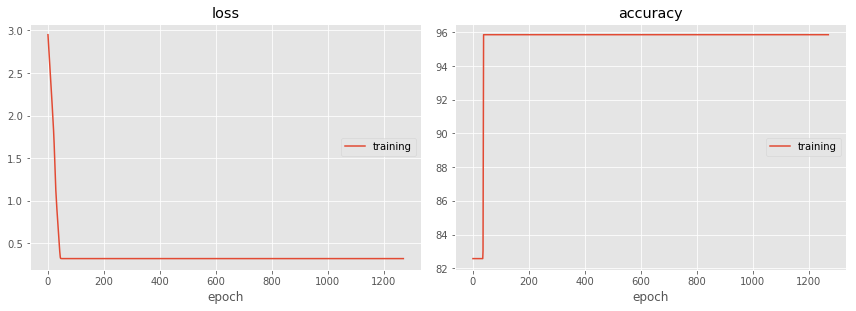

Epoch:  1270, Loss: 0.317849, Accuracy: 95.85%
stagnan


In [91]:
loss_history = []
acc_history = []
liveplot = PlotLosses()

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0
loss_disp_true = False
loss_avg = 0.0
old_loss_avg = 0.0
loss_cum = 0.0
need_one_more_iteration = True

early_stop_loss_counter = 0
not_early_stop = True

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    print("Initialized")
    while ((acc < 100) or need_one_more_iteration) and not_early_stop:
        if (acc >= 100):
            need_one_more_iteration = False
            
        epoch_idx += 1
        acc_cum = 0
        for step in range(int(num_batches)):
            offset = (step * batch_size)
            if num_samples > offset + batch_size:
                batch_limit = offset + batch_size
            else:
                batch_limit = num_samples
                loss_disp_true = True
                
            _current_state = np.zeros((batch_limit-offset, state_size))
            _current_state1 = np.zeros((batch_limit-offset, state_size))
            _current_state2 = np.zeros((batch_limit-offset, state_size))
            batch_data = train_dataset_reform[offset:(batch_limit), :]
            batch_labels = train_label_hot[offset:(batch_limit), :]
            
            # calculate loss, gradient step, 
            l, _train_step, _current_state, _current_state1, _current_state2, predictions = sess.run(
                [total_loss, train_step, current_state, current_state1, current_state2, train_predictions],
                feed_dict={
                    tf_train_dataset:batch_data,
                    tf_train_labels:batch_labels,
                    # it was part of computational graph, where the init_state is the placeholder
                    init_state:_current_state,
                    init_state1:_current_state1,
                    init_state2:_current_state2
                })
            
            acc_temp =  accuracy_multilabel_softmax(predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            loss_cum += l
            if loss_disp_true:
                loss_disp_true = False
                loss_avg = loss_cum/num_batches
                loss_cum = 0
                loss_history.append(loss_avg)
                acc_history.append(acc)
                liveplot.update({
                    'accuracy': acc,
                    # 'val_accuracy': 1 - np.random.rand() / (i + 0.5),
                    'loss': loss_avg,
                    # 'val_mse': 1. / (i + 0.5)
                })
                liveplot.draw()
                print("Epoch:{0:6d}, Loss: {1:8.6f}, Accuracy:{2:6.2f}%".format(epoch_idx, loss_avg, acc))
                
                if loss_avg == old_loss_avg:
                    print('stagnan')
                    early_stop_loss_counter += 1
                    if early_stop_loss_counter == 100:
                        not_early_stop = False
                    
                old_loss_avg = loss_avg


In [49]:
early_stop_loss_counter

100

In [35]:
# predictions
predictions_soft = np.zeros_like(predictions)
predictions_soft[np.arange(len(predictions)), predictions.argmax(1)] = 1

In [39]:
np.mean(batch_labels[np.arange(len(batch_labels)), predictions_soft.argmax(1)])

0.93402064

In [ ]:
"""
    # accuracy
    _current_state = np.zeros((batch_size, state_size))
    acc = 0
    total_acc = 0
    for batch_idx in range(num_batches):
        start_idx = batch_idx * truncated_backprop_length
        end_idx = start_idx + truncated_backprop_length
        
        batchX = x[:,start_idx:end_idx]
        batchY = y[:,start_idx:end_idx]

        # calculate loss, gradient step, 
        _predictions_series, _labels_series = sess.run([predictions_series, labels_series],
            feed_dict={
                batchX_placeholder:batchX,
                batchY_placeholder:batchY,
                # it was part of computational graph, where the init_state is the placeholder
                init_state:_current_state
            })
        acc = accuracy_independent( _predictions_series, _labels_series)
        print("batch:",batch_idx,", accuracy:",acc)
        total_acc += acc
    
    print(total_acc/num_batches)
# plt.ioff()
# plt.show()
"""